In [2]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter # print to tensorboard
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors


from src.models.utils.create_batch import EarthDataTrain
from src.models.model.model import Generator, Discriminator, init_weights
from src.models.loss.wasserstein import gradient_penalty

# to clear outputs from cells
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:


#######################################################
# Set Hyperparameters
#######################################################

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

LEARNING_RATE = 1e-4
NUM_EPOCHS = 2
BATCH_SIZE = 2
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
GEN_PRETRAIN_EPOCHS= 80 # number of epochs to pretrain generator

#######################################################

# set summary writer for Tensorboard
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

# https://stackoverflow.com/q/43959474/9214620
# convert = plt.get_cmap(cm.inferno)
convert = plt.get_cmap(cm.hsv)
norm = colors.Normalize(vmin=0,vmax=1)

root_dir = Path.cwd().parent.parent # set the root directory as a Pathlib path
print(root_dir)

path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

loader = DataLoader(
    earth_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

gen = Generator(in_chan=4, out_chan=4, scale_factor=8, chan_base=32, chan_min=32, chan_max=64, cat_noise=True).to(device)
critic = Discriminator(in_chan=8, out_chan=8, scale_factor=8, chan_base=32, chan_min=32, chan_max=64).to(device)

# initialize weights
gen.apply(init_weights)
critic.apply(init_weights)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

gen.train()
critic.train()


for epoch in range(NUM_EPOCHS):
    print('epoch', epoch)


    for batch_idx, data in enumerate(loader):
        x_truth = data['truth'].to(device)
        x_up = data['upsampled'].to(device)
        x_input = data['input'].to(device)

        # pre-train the generator with simple MSE loss
        if epoch < GEN_PRETRAIN_EPOCHS:
            criterion = nn.MSELoss()
            gen_fake = gen(x_input)
            loss_mse = criterion(gen_fake, x_truth)
            gen.zero_grad()
            loss_mse.backward()
            opt_gen.step()

        # after pre-training of generator, enter the 
        # full training loop and train critic (e.g. discriminator) too
        else:
            # train critic
            for _ in range(CRITIC_ITERATIONS):
                fake = gen(x_input)
                critic_real = critic(torch.cat([x_truth, x_up], dim=1)).view(-1)
                critic_fake = critic(torch.cat([fake, x_up], dim=1)).view(-1)
                
                gp = gradient_penalty(critic, 
                                    torch.cat([x_truth, x_up], dim=1), # real
                                    torch.cat([fake, x_up], dim=1),  # fake
                                    device=device)

                loss_critic = (
                        -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
                    )
                
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                opt_critic.step()

            # train generator after every N critic iterations
            gen_fake = critic(torch.cat([fake, x_up], dim=1)).reshape(-1)
            loss_gen = -torch.mean(gen_fake)
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
        plt.switch_backend('agg')    
        with torch.no_grad():
            fake = gen(x_input).cpu()[0,0,0,:,:]
            print('fake.shape:', fake.shape, type(fake))
            fig, ax = plt.subplots(1,1, figsize=(6,6))
            ax.pcolormesh(fake, cmap='inferno')
            ax.set_aspect(1)
#             fake = convert(norm(fake))[:,:,:,:3]
#             fake = convert(fake)[:,:,:,:3]
#             fake = torch.tensor(fake)
#             print('fake.shape:', fake.shape, type(fake))
#             fake = rgba2rgb(fake)
#             fake = torch.movedim(torch.tensor(fake),3,1)
            
#             fake = torch.unsqueeze(fake, 1)
#             fake = torch.tensor(convert(norm(fake[:,0,:,:].cpu()))[:,:,:,:3])
            
#             x_truth = x_truth.cpu()[:2,0,0,:,:]
#             print('x_truth.shape:', x_truth.shape, type(fake))
#             x_truth = convert(norm(x_truth))[:,:,:,:3]
#             x_truth = convert(x_truth)[:,:,:,:3]
#             x_truth = torch.unsqueeze(x_truth, 1)
#             print('x_truth.shape:', x_truth.shape, type(x_truth))
#             x_truth = torch.movedim(torch.tensor(x_truth),3,1)
#             x_truth = torch.tensor(convert(norm(x_truth[:,0,:,:].cpu()))[:,:,:,:3])
#             img = torch.cat((fake, x_truth), dim=0)
            # take out (up to) 32 examples
#             img_grid_real = torchvision.utils.make_grid(x_truth, normalize=True, nrow=2)
#             img_grid_fake = torchvision.utils.make_grid(fake, normalize=True, nrow=2)
            writer_fake.add_figure("Fake", fig, global_step=step)
#             writer_real.add_image("Real", img_grid_real, global_step=step)
#             writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1
            
clear_output(wait=False)

In [ ]:
# fake.shape: (2, 118, 38, 3)
# x_truth.shape: (2, 118, 38, 3)

In [182]:
fake = gen(x_input).cpu()[0,0,0,:,:]

In [190]:
img.shape

torch.Size([4, 3, 118, 38])

In [183]:
fake.shape

torch.Size([118, 38])

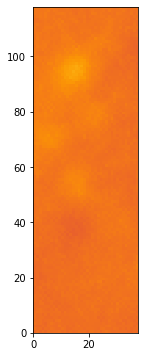

In [184]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pcolormesh(fake.detach(), cmap='inferno', 
              vmin=0, vmax=1
             )
ax.set_aspect(1)

IndexError: too many indices for tensor of dimension 4

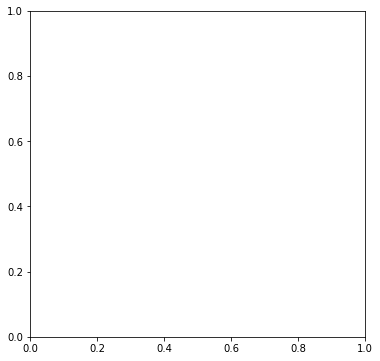

In [186]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pcolormesh(x_truth.cpu().detach()[0,0,0,:,:], cmap='inferno', 
              vmin=0, vmax=1
             )
ax.set_aspect(1)

In [128]:
convert = plt.get_cmap(cm.inferno)
norm = colors.Normalize(vmin=0,vmax=1)

numpy_output_static = convert(norm(fake.cpu()))[:,:,:,:3]

In [129]:
numpy_output_static.shape

(2, 118, 38, 3)

In [131]:
n = torch.movedim(torch.tensor(numpy_output_static),3,1)
n.shape

torch.Size([3, 2, 118, 38])

In [49]:
img_grid_fake.shape

torch.Size([3, 122, 82])

In [14]:
x_truth.shape

torch.Size([2, 4, 198, 118, 38])

In [15]:
x_truth[:,0,0,:,:].shape

torch.Size([2, 118, 38])

In [46]:
x = torch.cat((x_truth, x_truth),dim=0)

In [47]:
x.shape

torch.Size([4, 1, 118, 38])

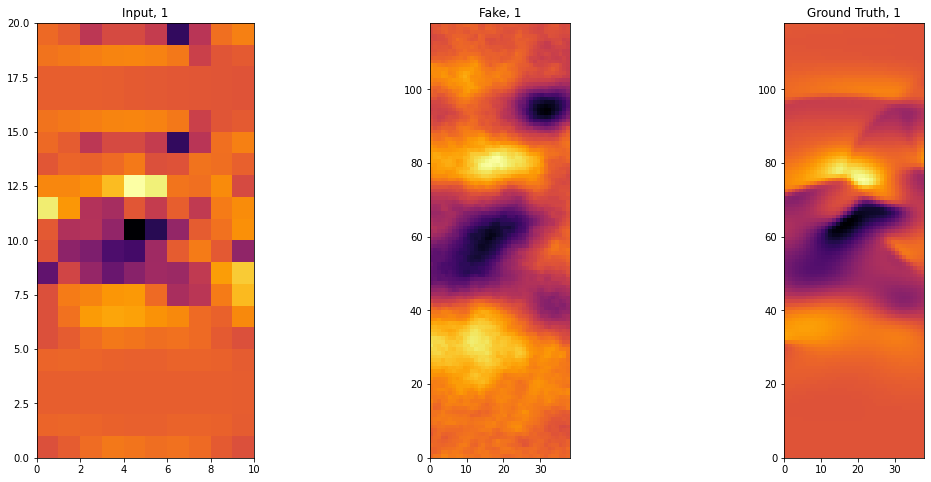

In [143]:
# randomly select image
data = earth_dataset[0]
x_input = data['input'].unsqueeze(0).to(device)
x_truth = data['truth'].unsqueeze(0).to(device)

with torch.no_grad():
    fake = gen(x_input).detach()

    
title_list = ['Input', "Fake", 'Ground Truth']
r_index = 1
var_to_plot = 3
    
# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
                                
        ax.pcolormesh(x_input[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
                
    # downscaled data
    if title == 'Fake':
                
        ax.pcolormesh(fake[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
           
        img = ax.pcolormesh(x_truth[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)

plt.show()

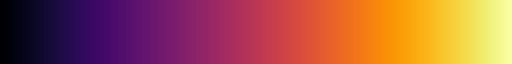

In [72]:
img.cmap

In [85]:
img.get_array().reshape(img._meshWidth, img._meshHeight).shape

(38, 118)

In [86]:
from matplotlib import cm
from matplotlib import colors

In [98]:
# https://stackoverflow.com/q/43959474/9214620
convert = plt.get_cmap(cm.inferno)
norm = colors.Normalize(vmin=0,vmax=1)

numpy_output_static = convert(norm(x_truth[0,var_to_plot,r_index,:,:].cpu()))

In [78]:
x_truth[0,var_to_plot,r_index,:,:].shape

torch.Size([118, 38])

In [77]:
numpy_output_static.shape

(118, 38, 4)

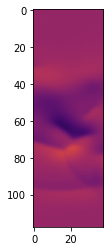

In [102]:
plt.imshow(numpy_output_static[:,:,:3],cmap = cm.inferno, aspect = 1)

In [70]:
img.C.ravel()

AttributeError: 'QuadMesh' object has no attribute 'C'

In [29]:
path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

loader = DataLoader(
    earth_dataset,
    batch_size=5,
    shuffle=True,
)

for batch_idx, data in enumerate(loader):
    x_truth = data['truth'].to('cpu')
    x_up = data['upsampled'].to('cpu')
    x_input = data['input'].to('cpu')

In [30]:
x_truth.shape

torch.Size([2, 4, 198, 118, 38])

In [34]:
img_grid_real = torchvision.utils.make_grid(x_truth[:2,0,0,:,:], normalize=True)
img_grid_real = torch.unsqueeze(img_grid_real, 1)

In [35]:
torchvision.utils.save_image(img_grid_real, 'img_grid.png', nrow=2)

In [36]:
img_grid_real.shape

torch.Size([2, 1, 118, 38])

In [7]:
writer_real.add_image("Real", img_grid_real, global_step=0)